In [1]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt

vector.register_awkward()

In [2]:
data_path = '../data/DoubleMuonLowMass_Run2018A.root'

data = uproot.open(f'{data_path}:Events;1')

In [3]:
data_length = len(data['event'].array())


target_hlt_keys = [
    'HLT_Tau3Mu_Mu5_Mu1_TkMu1_IsoTau10_Charge1',
    'HLT_Tau3Mu_Mu7_Mu1_TkMu1_IsoTau15_Charge1',
    'HLT_Tau3Mu_Mu7_Mu1_TkMu1_Tau15_Charge1',
]

data_hlt_keys = data.keys(filter_name='HLT_Tau3Mu*')

hlt_keys = [hlt_key for hlt_key in target_hlt_keys if hlt_key in data_hlt_keys]

print(f"hlt_keys: {hlt_keys}")

hlt_mask = ak.Array(np.zeros(data_length, dtype=bool))

for hlt_key in hlt_keys:
    hlt_mask = hlt_mask | data[hlt_key].array()


print(f"Before filtering, Event #: {data_length}")
print(f"After filtering, Event #: {np.count_nonzero(hlt_mask)}")

hlt_keys: ['HLT_Tau3Mu_Mu7_Mu1_TkMu1_IsoTau15_Charge1', 'HLT_Tau3Mu_Mu7_Mu1_TkMu1_Tau15_Charge1']
Before filtering, Event #: 2040266
After filtering, Event #: 322902


In [4]:
#muon_mediumId = data['Muon_mediumId'].array()[hlt_mask]

muon = vector.zip(
    {
        #'event': data['event'].array()[hlt_mask],
        'pt': data['Muon_pt'].array()[hlt_mask],
        'eta': data['Muon_eta'].array()[hlt_mask],
        'phi': data['Muon_phi'].array()[hlt_mask],
        'mass': data['Muon_mass'].array()[hlt_mask],
        'charge': data['Muon_charge'].array()[hlt_mask],
        'mediumId': data['Muon_mediumId'].array()[hlt_mask]
    }
)

muon_mask1 = (muon.pt > 3.5) & (abs(muon.eta) <= 1.2)
muon_mask2 = (muon.pt > 2.0) & (abs(muon.eta) <= 2.4) & (abs(muon.eta) >= 1.2)

muon_mask = ak.count((muon_mask1 | muon_mask2) & muon.mediumId, axis=1) >= 3

muon = muon[muon_mask]

print(ak.count(muon, axis=1))
print(muon.show(10))


[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, ..., 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3]
[[{rho: 13, phi: 0.76, eta: 0.813, tau: 0.106, charge: 1, ...}, ..., {...}],
 [{rho: 7.61, phi: -1.81, eta: -2.1, tau: 0.106, charge: -1, ...}, ..., {...}],
 [{rho: 7.49, phi: -0.707, eta: -0.728, tau: 0.106, charge: 1, ...}, ...],
 [{rho: 19.9, phi: 0.702, eta: 0.836, tau: 0.106, charge: 1, ...}, ..., {...}],
 [{rho: 9.19, phi: -2.04, eta: 1.39, tau: 0.106, charge: -1, ...}, ..., {...}],
 ...,
 [{rho: 8.39, phi: -0.111, eta: 0.764, tau: 0.106, charge: -1, ...}, ...],
 [{rho: 14.1, phi: 2.82, eta: -1.83, tau: 0.106, charge: -1, ...}, ..., {...}],
 [{rho: 15.7, phi: -2.69, eta: -1.31, tau: 0.106, charge: 1, ...}, ..., {...}],
 [{rho: 10, phi: -0.968, eta: -2.04, tau: 0.106, charge: 1, ...}, ..., {...}]]
None


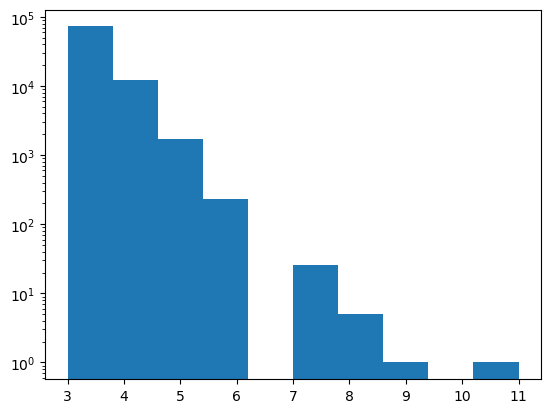

In [5]:
plt.hist(ak.count(muon, axis=1), log=True)
plt.show()

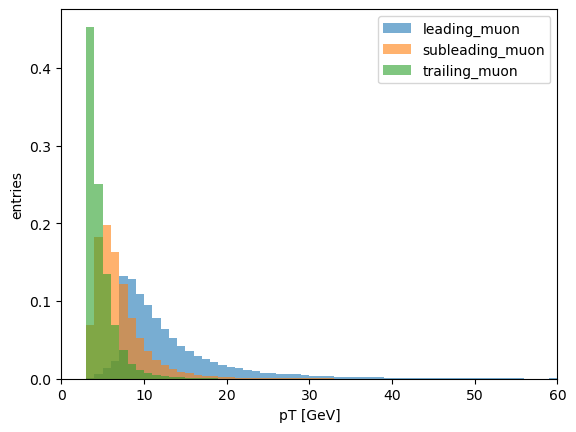

In [6]:
plt.hist(muon.pt[:, 0],              density=True, bins=60, alpha=0.6, range=(0, 60), label="leading_muon")
plt.hist(muon.pt[:, 1],              density=True, bins=60, alpha=0.6, range=(0, 60), label="subleading_muon")
plt.hist(ak.flatten(muon.pt[:, 2:]), density=True, bins=60, alpha=0.6, range=(0, 60), label="trailing_muon")
plt.xlim(0, 60)
plt.xlabel("pT [GeV]")
plt.ylabel("entries")
plt.legend()
plt.show()

In [25]:
# τ candidates are formed in each event by combining all the possible triplets of muons passing the pre-selection, that is, satisfying the Medium ID requirements and being matched to the objects firing the trigger (for further details on the trigger matching, see Sec.5.4).
muon1, muon2, muon3 = ak.unzip(ak.combinations(muon, 3))
tau_candidate = muon1 + muon2 + muon3
tau_candidate['charge'] = muon1['charge'] + muon2['charge'] + muon3['charge']


# The invariant mass of the τ candidates should be lower than 3 GeV,
tau_candidate = tau_candidate[tau_candidate.mass < 3]


# τ candidate charge has to be ±1
print("#"*150)
print(f"Events Number three muons charge sum != 1 or -1: {np.count_nonzero(~((tau_candidate.charge == 1) | (tau_candidate.charge == -1)))}")
tau_candidate = tau_candidate[(tau_candidate.charge == 1) | (tau_candidate.charge == -1)]
tau_candidate.show(limit_rows=4, limit_cols=300)


# The three muons are fit to a common vertex through a kinematic fit [31], and the vertex is required to be valid.
# The muon tracks are refitted, applying this vertex as a constrain, and the refitted quantities are used in all the following steps of the analysis.
# τ candidates are discarded if any of the three muons can make a “good” vertex with an extra opposite charged muon (not already considered as part of the τ candidate)

[[{rho: 22.3, phi: 0.755, eta: 0.844, tau: 1.76, charge: -1}],
 [{rho: 7.28, phi: -1.8, eta: -2.33, tau: 34.3, charge: -1}],
 ...,
 [{rho: 12.5, phi: -1.16, eta: -2.38, tau: 21.7, charge: 1}]]
######################################################################################################################################################
[[{rho: 22.3, phi: 0.755, eta: 0.844, tau: 1.76, charge: -1}],
 [],
 ...,
 []]
######################################################################################################################################################
Events Number three muons charge sum != 1 or -1: 1518
[[{rho: 22.3, phi: 0.755, eta: 0.844, tau: 1.76, charge: -1}],
 [],
 ...,
 []]
